This notebook presents the core implementations of our method and uses that to train ensembles of 2 or 3 ResNet-18 models on CIFAR-10. It computes the transferability rates for ```Orig```, ```C=1.0```, and ```LOTOS C=1.0 mal=0.8``` using white-box attack as explained in our paper and generates similar plots to the ones we have in the experiments section:

In [11]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision
from advertorch.attacks.utils import attack_whole_dataset
from advertorch.attacks import LinfPGDAttack

from models.resnet import ResNet18
from models.resnet_orig import ResNet18_orig

import random
import numpy as np
import pandas as pd
import time

from utils.Empirical.utils_ensemble import AverageMeter, requires_grad_

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Setting a set of parameters that are the default ones for our experiments:

In [12]:
freq = 50
conv_freq = 1
effective_epoch = 0
conv_only = True
conv_1st_only = False
num_models = 2
opt_iter = 1
clip_steps = 100
bn_flag = False
epochs = 121
in_chan = 3
num_classes = 10
bottom_clip = 0.8 # mal value
cat_bottom_clip = 0.8 # mal value for the concatenation when batchnorm is used
conv_factor = 0.05
cat_factor = 0.05
adv_eps = 0.04

Helper function to extract and compute the average of transferability rate, roubstness, and accuracy for the models in the ensemble for each epoch:

In [13]:
def compute_trans(sub_df, model_count=3):
    ### computing the average of the transferability rates from pairs of models
    if model_count == 3:
        trans_mat = sub_df[['t0', 't1', 't2']].values
    elif model_count == 2:
        trans_mat = sub_df[['t0', 't1']].values
    acc_avg = sub_df['acc'].mean()

    # compute the sum of off-diagonal values of trans_mat:
    off_diagonal_sum = np.sum(trans_mat) - np.trace(trans_mat)
    if model_count == 3:
        trans_rate = off_diagonal_sum / 6.
    elif model_count == 2:
        trans_rate = off_diagonal_sum / 2.

    if model_count == 3:
        robustness = 1. - np.trace(trans_mat) / 3.
    elif model_count == 2:
        robustness = 1. - np.trace(trans_mat) / 2.

    return trans_rate, robustness, acc_avg

In [14]:
def summarize(df, num_models):
    trans_df_1_group = df.groupby('epoch')
    results = []
    for idx, group in trans_df_1_group:
        group = group[:num_models]
        trans_rate, robustness, acc_avg = compute_trans(group, num_models)
        results.append([int(idx),trans_rate, robustness, acc_avg])
    res_df = pd.DataFrame(results, columns=['epoch', 'trans', 'robust', 'acc'])
    return res_df

Helper function to use the white-box attacks (see our paper for details) to compute the transferability rate of adversarial examples between each ordered pair of models in the ensemble:

In [15]:
def evaltrans_correct(loader, models, criterion, epoch):
    ### performing white-box attack to compute the transferability rates
    for i in range(len(models)):
        models[i].eval()

    adv = []
    advsamples_lst = []
    pred_lst = []
    advpred_lst = []   
    label = None
    for i in range(len(models)):
        curmodel = models[i]
        adversary = LinfPGDAttack(
            curmodel, loss_fn=criterion, eps=adv_eps,
            nb_iter=50, eps_iter=adv_eps / 10, rand_init=True, clip_min=0., clip_max=1.,
            targeted=False)

        adv.append(adversary)
        advsamples, label, pred, advpred = attack_whole_dataset(adversary, loader, device=device)
        advsamples_lst.append(advsamples)
        pred_lst.append(pred)
        advpred_lst.append(advpred)

    trans_list = []
    accs = np.zeros(num_models)
    trans = np.zeros((num_models, num_models))
    for i in range(len(models)):
        _, label, pred, advpred = advsamples_lst[i], label, pred_lst[i], advpred_lst[i]

        for j in range(len(models)):
            if j==i:
                if trans[i][j] > 0.00000001:
                    continue
                y = label[label == pred]
                accs[i] = y.size(0) / label.size(0)
                y_wrong = label[(label == pred) & (advpred != label)]
                trans[i][j] = y_wrong.size(0) / len(y)

            else:
                inputc = _[(label == pred) & (advpred != label) & (label==pred_lst[j])]
                print('model: ', i, inputc.size(0), ' out of ', _.size(0))
                y = label[(label == pred) & (advpred != label) & (label==pred_lst[j])]
            
                with torch.no_grad():
                    for r in range((inputc.size(0) - 1) // 100 + 1):
                        inputc_sub = inputc[r * 200: min((r + 1) * 200, inputc.size(0))]
                        if len(inputc_sub) == 0:
                            break
                        y_sub = y[r * 200: min((r + 1) * 200, inputc.size(0))]
                        __ = adv[j].predict(inputc_sub)
                        output = (__).max(1, keepdim=False)[1]
                        trans[i][j] += (output != y_sub).sum().item()
                    trans[i][j] /= len(y)

            print(i, j, trans[i][j])

        new_list = [epoch]
        for k in range(num_models):
            new_list.append(trans[i,k])
        new_list.append(accs[i])
        new_tup = tuple(new_list)
        trans_list.append(new_tup)

    return trans_list

The function used for training each each epoch. By setting the ```lotos_flag``` to true, it uses LOTOS for training, otherwise it uses regular training.

In [16]:
def Naive_Trainer_ortho(loader: DataLoader, models, criterion, optimizer, epoch: int, device: torch.device, lotos_flag=False, 
                        catclip=False, no_effect_epochs=0, batch_counter=0, mal_freq=100, conv_freq=50, layer_1_only=False, 
                        conv_1st_only=False, lsv_list_dict={}, lsv_list_dict_conv={}, conv_only=False, conv_factor=0.05, cat_factor=0.05):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    reg_losses = AverageMeter()
    ortho_losses = AverageMeter()

    end = time.time()
    ortho_total = 0.

    ortho_flag = lotos_flag
    decrement = 0.01
    weights = torch.from_numpy(np.array([1 - decrement*i for i in range(100)])).to(device)

    print_freq = max(1000, 10*conv_freq)
    if len(lsv_list_dict) == 0:
        print('initiating lsv list dict')
        for j in range(num_models):
            lsv_list_dict[j] = None
            lsv_list_dict_conv[j] = None

    for i in range(num_models):
        models[i].train()
        requires_grad_(models[i], True)

    cat_counter_info = 0
    conv_counter_info = 0
    for i, (inputs, targets) in enumerate(loader):
        data_time.update(time.time() - end)
        inputs, targets = inputs.to(device), targets.to(device)
        batch_size = inputs.size(0)
        loss_std = 0
        ortho_loss = 0
        ortho_loss_conv = 0

        for j in range(num_models):
            logits = models[j](inputs)
            loss = criterion(logits, targets)
            loss_std += loss

            if not ortho_flag:
                continue
            if i == len(loader)-1:
                continue

            VT_list = []
            VT_list_conv = []
            idx = 0

            conv_count = 0
            cat_counter_info = 0
            conv_counter_info = 0

            for (m_name, m) in models[j].named_modules():
                condition = isinstance(m, (torch.nn.Conv2d))
                condition_conv = isinstance(m, (torch.nn.Conv2d))
                if not condition_conv and conv_only:
                    continue
                if catclip:
                    condition = not conv_only and not isinstance(m, (torch.nn.Conv2d)) and (not isinstance(m, torch.nn.BatchNorm2d) and not isinstance(m, torch.nn.Linear))

                if not condition_conv and epoch < no_effect_epochs:
                    conv_factor = 0.0
                    cat_factor = 0.0

                if condition or condition_conv:
                    attrs = vars(m)
                    for item in attrs.items():
                        if item[0] == '_buffers' and 'weight_VT' in item[1]:
                            VT = item[1]['weight_VT']
                            if batch_counter != 0:
                                first_flag = True
                                for k in range(num_models):
                                    if k == j:
                                        if condition_conv:
                                            if batch_counter % print_freq != 0:
                                                continue
                                            prev_VT = lsv_list_dict_conv[k]
                                            sing_vector = prev_VT[conv_count]
                                        else:
                                            if batch_counter % mal_freq != 0:
                                                continue
                                            prev_VT = lsv_list_dict[k]
                                            sing_vector = prev_VT[idx]

                                        sing_vector = torch.nn.parameter.Parameter(data=sing_vector, requires_grad=False)
                                        op_shape = [i for i in range(1, len(sing_vector.shape))]
                                        lsv_check = torch.sqrt(torch.sum(m(sing_vector) **2, axis=op_shape))/torch.sqrt(torch.sum(sing_vector **2, axis=op_shape)) 
                                        lsv_check_noBias = torch.sqrt(torch.sum( (m(sing_vector) - m(torch.zeros_like(sing_vector) ) )**2, axis=op_shape))/torch.sqrt(torch.sum(sing_vector **2, axis=op_shape)) 
                                        continue

                                    if condition_conv:
                                        prev_VT_list = lsv_list_dict_conv[k]
                                    else:
                                        prev_VT_list = lsv_list_dict[k]

                                    if not condition_conv and layer_1_only and idx > 0:
                                        continue
                                    if condition_conv and conv_1st_only and conv_count > 0:
                                        continue

                                    if condition_conv:
                                        bad_vector = prev_VT_list[conv_count]
                                    else:
                                        bad_vector = prev_VT_list[idx]

                                    if batch_counter % mal_freq != 0 and not condition_conv:
                                        continue
                                    if batch_counter % conv_freq != 0 and condition_conv:
                                        continue

                                    bad_vector = torch.nn.parameter.Parameter(data=bad_vector, requires_grad=False)
                                    op_shape = [i for i in range(1, len(bad_vector.shape))]
                                    bad_vec_length = torch.sqrt(torch.sum((m(bad_vector) - m(torch.zeros_like(bad_vector)) )**2, axis=op_shape))/torch.sqrt(torch.sum(bad_vector **2, axis=op_shape)) ##### fix this shit for multiple vectors!                       

                                    if condition_conv:
                                        bad_vec_length_thresh = torch.nn.functional.relu(bad_vec_length-bottom_clip)
                                    else:
                                        bad_vec_length_thresh = torch.nn.functional.relu(bad_vec_length-cat_bottom_clip)

                                    bad_vec_length_weighted = torch.sum(torch.mul(bad_vec_length_thresh, weights[:len(bad_vec_length_thresh)]))/torch.sum(weights[:len(bad_vec_length_thresh)])

                                    if condition_conv:
                                        ortho_loss_conv += conv_factor * bad_vec_length_weighted
                                        conv_counter_info += 1
                                    if not condition_conv:
                                        ortho_loss += cat_factor * bad_vec_length_weighted
                                        cat_counter_info += 1

                            if condition_conv:
                                VT_list_conv.append(VT.detach())
                                conv_count += 1
                            else:
                                VT_list.append(VT.detach())
                                idx += 1

            lsv_list_dict_conv[j] = VT_list_conv
            if not conv_only:
                lsv_list_dict[j] = VT_list

        reg_losses.update(loss_std.item(), batch_size)
        loss = loss_std

        if ortho_flag:
            pair_count = num_models * (num_models - 1) / 2
            conv_counter_info = conv_counter_info // (num_models-1)
            cat_counter_info = cat_counter_info // (num_models-1)
            
            conv_normalizer = conv_counter_info*pair_count
            cat_normalizer = cat_counter_info*pair_count

            conv_normalizer = 1.
            cat_normalizer = 1.

            if ortho_loss_conv > 0 and (batch_counter % 200 != 199) and batch_counter > 0 and conv_counter_info > 0 and (batch_counter % conv_freq) == 0:
                loss += ortho_loss_conv / conv_normalizer #/ (conv_counter_info*pair_count)
                ortho_total += ortho_loss_conv.item() / conv_normalizer #/ (conv_counter_info*pair_count)
                if batch_counter % print_freq == 0:
                    print('pairs', pair_count,  'conv', conv_counter_info,  'ortho loss conv: ', ortho_loss_conv.item()/ conv_normalizer )

            # if batch_counter % 200 != 199 and not conv_only and batch_counter > 0 and cat_counter_info > 0 and (batch_counter % mal_freq) == 50:
            if not conv_only and batch_counter > 0 and cat_counter_info > 0 and (batch_counter % mal_freq) == 50:
                loss += ortho_loss / cat_normalizer #/ (cat_counter_info*pair_count)
                ortho_total += ortho_loss.item() / cat_normalizer #/ (cat_counter_info*pair_count)
                if batch_counter % mal_freq == 0:
                    print('pairs', pair_count, 'cat', cat_counter_info, 'ortho loss cat: ', ortho_loss.item() / cat_normalizer)

        losses.update(loss.item(), batch_size)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        batch_counter += 1

    print('Epoch: ', epoch, 'Loss: ', losses.avg, 'Loss_std: ', reg_losses.avg, 'Ortho_loss: ', ortho_losses.avg, 'ortho total:', ortho_total)

    return losses.avg, batch_counter, lsv_list_dict, lsv_list_dict_conv

Reading CIFAR-10 dataset and preparing data loaders:

In [17]:
### Reading CIFAR10:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10( root='./data', train=True, download=True, transform=transform_train)
train_loader = torch.utils.data.DataLoader( trainset, batch_size=128, shuffle=True, num_workers=1)

testset = torchvision.datasets.CIFAR10( root='./data', train=False, download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader( testset, batch_size=128, shuffle=False, num_workers=1)

100.0%


Function to perform the training on ensembles. For ```Orig``` ensembles, both ```clip_flag``` and ```lotos_flag``` should be set to False. For ```C=1```, the ```clip_flag``` should be set the True. For ```LOTOS```, both flags should be set to True:

In [18]:
def train_ensemble(num_models, clip_flag=False, lotos_flag=False, seed_val=0):
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)
    np.random.seed(seed_val)
    random.seed(seed_val)

    model = []
    for i in range(num_models):
        if clip_flag:
            submodel = ResNet18(in_chan=in_chan, num_classes=num_classes, device=device, clip_flag=True, bn=False, clip_steps=clip_steps, writer=None)
        else:
            submodel = ResNet18_orig(in_chan=in_chan, num_classes=num_classes, bn=False, device=device)
        submodel = nn.DataParallel(submodel)
        model.append(submodel)
    print("Model loaded")

    criterion = nn.CrossEntropyLoss().cuda()

    param = list(model[0].parameters())
    for i in range(1, num_models):
        param.extend(list(model[i].parameters()))

    optimizer = optim.SGD(param, lr=0.1, momentum=0.9, weight_decay=5e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.1)

    trans_list = []
    batch_counter = 0
    lsv_list_dict = {}
    lsv_list_dict_conv = {}
    for epoch in range(epochs):
        start = time.time()
        train_loss, batch_counter, lsv_list_dict, lsv_list_dict_conv = Naive_Trainer_ortho(train_loader, model, criterion, optimizer, 
                                                                                           epoch, device, lotos_flag=lotos_flag, catclip=False, no_effect_epochs=effective_epoch, 
                                                                                           batch_counter=batch_counter, mal_freq=freq, conv_freq=conv_freq, layer_1_only=False, 
                                                                                           conv_1st_only=conv_1st_only, lsv_list_dict=lsv_list_dict, lsv_list_dict_conv=lsv_list_dict_conv, 
                                                                                           conv_factor=conv_factor, cat_factor=cat_factor,
                                                                                           conv_only=conv_only)
        print('time: ', time.time() - start)

        if epoch % 20 == 0 and epoch >= 60: 
            trans_list_new = evaltrans_correct(test_loader, model, criterion, epoch)
            trans_list += trans_list_new

        scheduler.step()

    col_names = ['epoch']
    for k in range(num_models):
        col_names.append('t' + str(k))
    col_names.append('acc')

    df = pd.DataFrame(trans_list, columns=col_names) 
    return df


Now running the training methods for 3 cases: ```Orig```, ```C=1.0```, and ```LOTOS C=1.0 mal=0.8```:

In [19]:
df_orig = train_ensemble(num_models, clip_flag=False, lotos_flag=False, seed_val=0)

Model loaded
initiating lsv list dict
Epoch:  0 Loss:  4.1711517015075685 Loss_std:  4.1711517015075685 Ortho_loss:  0 ortho total: 0.0
time:  21.810686111450195
Epoch:  1 Loss:  3.5729671159362795 Loss_std:  3.5729671159362795 Ortho_loss:  0 ortho total: 0.0
time:  22.282235860824585
Epoch:  2 Loss:  3.1105881300354006 Loss_std:  3.1105881300354006 Ortho_loss:  0 ortho total: 0.0
time:  22.268751621246338
Epoch:  3 Loss:  2.7403625202941893 Loss_std:  2.7403625202941893 Ortho_loss:  0 ortho total: 0.0
time:  25.719451189041138
Epoch:  4 Loss:  2.454787545890808 Loss_std:  2.454787545890808 Ortho_loss:  0 ortho total: 0.0
time:  25.305118560791016
Epoch:  5 Loss:  2.2181022617340087 Loss_std:  2.2181022617340087 Ortho_loss:  0 ortho total: 0.0
time:  27.440547466278076
Epoch:  6 Loss:  2.0530935596466064 Loss_std:  2.0530935596466064 Ortho_loss:  0 ortho total: 0.0
time:  22.71924090385437
Epoch:  7 Loss:  1.8787254196929932 Loss_std:  1.8787254196929932 Ortho_loss:  0 ortho total: 0.0

In [20]:
df_clip = train_ensemble(num_models, clip_flag=True, lotos_flag=False, seed_val=0)

!!!!!!! Clipping is active !!!!!!!! clip val:  1.0
def iter:  1
opt step size:  0.35
!!!!!!! Clipping is active !!!!!!!! clip val:  1.0
def iter:  1
opt step size:  0.35
!!!!!!! Clipping is active !!!!!!!! clip val:  1.0
def iter:  1
opt step size:  0.35
!!!!!!! Clipping is active !!!!!!!! clip val:  1.0
def iter:  1
opt step size:  0.35
!!!!!!! Clipping is active !!!!!!!! clip val:  1.0
def iter:  1
opt step size:  0.35
!!!!!!! Clipping is active !!!!!!!! clip val:  1.0
def iter:  1
opt step size:  0.35
!!!!!!! Clipping is active !!!!!!!! clip val:  1.0
def iter:  1
opt step size:  0.35
!!!!!!! Clipping is active !!!!!!!! clip val:  1.0
def iter:  1
opt step size:  0.35
!!!!!!! Clipping is active !!!!!!!! clip val:  1.0
def iter:  1
opt step size:  0.35
!!!!!!! Clipping is active !!!!!!!! clip val:  1.0
def iter:  1
opt step size:  0.35
!!!!!!! Clipping is active !!!!!!!! clip val:  1.0
def iter:  1
opt step size:  0.35
!!!!!!! Clipping is active !!!!!!!! clip val:  1.0
def iter:  1
o

In [21]:
df_lotos = train_ensemble(num_models, clip_flag=True, lotos_flag=True, seed_val=0)

!!!!!!! Clipping is active !!!!!!!! clip val:  1.0
def iter:  1
opt step size:  0.35
!!!!!!! Clipping is active !!!!!!!! clip val:  1.0
def iter:  1
opt step size:  0.35
!!!!!!! Clipping is active !!!!!!!! clip val:  1.0
def iter:  1
opt step size:  0.35
!!!!!!! Clipping is active !!!!!!!! clip val:  1.0
def iter:  1
opt step size:  0.35
!!!!!!! Clipping is active !!!!!!!! clip val:  1.0
def iter:  1
opt step size:  0.35
!!!!!!! Clipping is active !!!!!!!! clip val:  1.0
def iter:  1
opt step size:  0.35
!!!!!!! Clipping is active !!!!!!!! clip val:  1.0
def iter:  1
opt step size:  0.35
!!!!!!! Clipping is active !!!!!!!! clip val:  1.0
def iter:  1
opt step size:  0.35
!!!!!!! Clipping is active !!!!!!!! clip val:  1.0
def iter:  1
opt step size:  0.35
!!!!!!! Clipping is active !!!!!!!! clip val:  1.0
def iter:  1
opt step size:  0.35
!!!!!!! Clipping is active !!!!!!!! clip val:  1.0
def iter:  1
opt step size:  0.35
!!!!!!! Clipping is active !!!!!!!! clip val:  1.0
def iter:  1
o

In [22]:
print(df_orig)

   epoch        t0        t1     acc
0     60  0.824739  0.821623  0.9095
1     60  0.823898  0.823857  0.8987
2     80  0.812996  0.835943  0.9203
3     80  0.808296  0.825475  0.9162
4    100  0.822866  0.843295  0.9219
5    100  0.833988  0.825865  0.9194
6    120  0.819305  0.840627  0.9231
7    120  0.842709  0.817787  0.9209


In [23]:
print(df_clip)


   epoch        t0        t1     acc
0     60  0.773452  0.805003  0.8912
1     60  0.859210  0.753593  0.8977
2     80  0.725689  0.857650  0.9183
3     80  0.837178  0.737552  0.9198
4    100  0.676016  0.873330  0.9056
5    100  0.859456  0.683820  0.9036
6    120  0.663143  0.867396  0.9081
7    120  0.884145  0.659411  0.9096


In [24]:
print(df_lotos)

   epoch        t0        t1     acc
0     60  0.719304  0.621961  0.8796
1     60  0.515124  0.808196  0.8931
2     80  0.708227  0.619055  0.9007
3     80  0.545991  0.785051  0.9151
4    100  0.660286  0.651832  0.8881
5    100  0.643649  0.707518  0.8992
6    120  0.649719  0.703100  0.8890
7    120  0.665716  0.704056  0.9049


Calculating the average transferability rate, robustness, and acc for each epoch for each ensemble:

In [25]:
orig_results = summarize(df_orig, num_models)
clip_results = summarize(df_clip, num_models)
lotos_results = summarize(df_lotos, num_models)

In [26]:
print('\nOrig ensemble:\n', orig_results)
print('\nC=1 ensemble:\n', clip_results)
print('\nLOTOS ensemble\n', lotos_results)


Orig ensemble:
    epoch     trans    robust      acc
0     60  0.822761  0.175702  0.90410
1     80  0.822119  0.180765  0.91825
2    100  0.838642  0.175635  0.92065
3    120  0.841668  0.181454  0.92200

C=1 ensemble:
    epoch     trans    robust      acc
0     60  0.832106  0.236478  0.89445
1     80  0.847414  0.268380  0.91905
2    100  0.866393  0.320082  0.90460
3    120  0.875771  0.338723  0.90885

LOTOS ensemble
    epoch     trans    robust      acc
0     60  0.568543  0.236250  0.88635
1     80  0.582523  0.253361  0.90790
2    100  0.647741  0.316098  0.89365
3    120  0.684408  0.323113  0.89695


Making the plots similar to the ones in the paper and saving them to ```figs``` folder:

In [ ]:
import matplotlib.pyplot as plt

plt.clf()
plt.plot(orig_results['epoch'], orig_results['trans'], label='Orig')
plt.plot(clip_results['epoch'], clip_results['trans'], label='C=1')
plt.plot(lotos_results['epoch'], lotos_results['trans'], label='LOTOS')
plt.legend()
plt.savefig('figs/transferability.png')
plt.clf()

plt.plot(orig_results['epoch'], orig_results['robust'], label='Orig')
plt.plot(clip_results['epoch'], clip_results['robust'], label='C=1')
plt.plot(lotos_results['epoch'], lotos_results['robust'], label='LOTOS')
plt.legend()
plt.savefig('figs/robustness.png')
plt.clf()

plt.plot(orig_results['epoch'], orig_results['acc'], label='Orig')
plt.plot(clip_results['epoch'], clip_results['acc'], label='C=1')
plt.plot(lotos_results['epoch'], lotos_results['acc'], label='LOTOS')
plt.legend()
plt.savefig('figs/accuracy.png')
plt.clf()

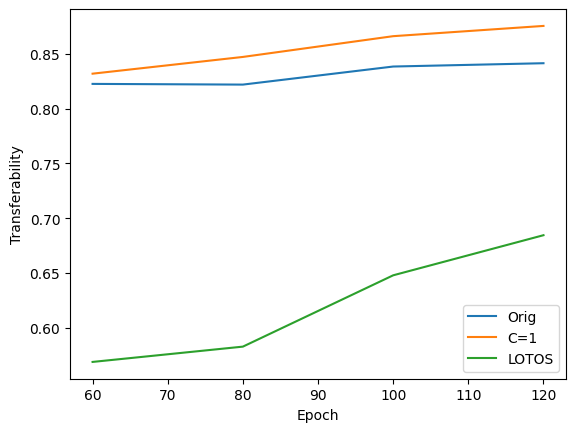

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt


plt.clf()
plt.plot(orig_results['epoch'], orig_results['trans'], label='Orig')
plt.plot(clip_results['epoch'], clip_results['trans'], label='C=1')
plt.plot(lotos_results['epoch'], lotos_results['trans'], label='LOTOS')
plt.xlabel('Epoch')
plt.ylabel('Transferability')
plt.legend()
plt.savefig('figs/transferability.png')
plt.show()

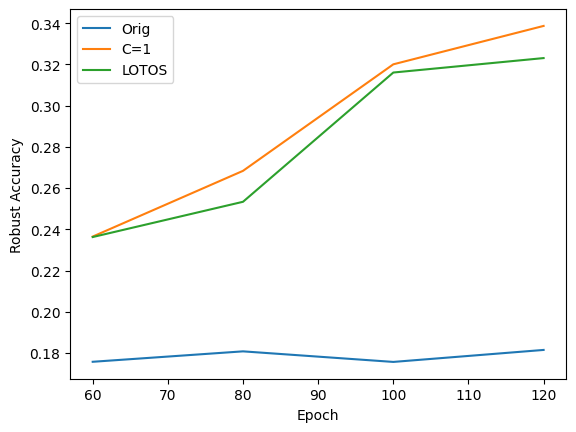

In [38]:
plt.clf()
plt.plot(orig_results['epoch'], orig_results['robust'], label='Orig')
plt.plot(clip_results['epoch'], clip_results['robust'], label='C=1')
plt.plot(lotos_results['epoch'], lotos_results['robust'], label='LOTOS')
plt.xlabel('Epoch')
plt.ylabel('Robust Accuracy') 
plt.legend()
plt.savefig('figs/robustness.png')
plt.show()

In [ ]:
plt.clf()

plt.plot(orig_results['epoch'], orig_results['acc'], label='Orig')
plt.plot(clip_results['epoch'], clip_results['acc'], label='C=1')
plt.plot(lotos_results['epoch'], lotos_results['acc'], label='LOTOS')
plt.xlabel('Epoch')
plt.ylabel('Accuracy') 
plt.legend()
plt.savefig('figs/accuracy.png')